<h1> Computing Sensitivity (Sobol) Indices

In many computational problems there are a few key inputs that actually dictate the state of the output. Computing the Sobol indices of the inputs is one approach to determine which inputs are the $\textit{drivers}$. Typically computation of the Sobol indices involves a large number of samples -- significantly more than required to get the variance in the data. However as shown in Blatman et al. [1], using orthogonal polynomials these can be computed with relative ease. In this notebook we demonstrate how we can compute these indices using effective quadratures. 

We consider the well-known piston problem from Kenett et al. [2] that is a non-linear, seven-dimensional problem that outputs the piston cycle time given various piston parameters. These parameters and their bounds are shown in the table below.

$$\begin{array}{lll} \hline
Variable & Range & Description \\ \hline
M & [30, 60] & Piston \; weight \; (kg)\\ 
S & [0.005, 0.0020] & Piston \; surface \; area \; (m^2)\\ 
V_0 & [0.002, 0.010] & Initial \; gas \; volume \; (m^3)\\ 
k & [1000,5000] & Spring \; coefficient \; (N/m)\\ 
P_0 & [90000, 110000] & Atmospheric \; pressure \; (N/m^2)\\ 
T_a & [290, 296] & Ambient \; temperature \; (K)\\ 
T_0 & [340, 360] & Filling \; gas \; temperature \; (K)\\ \hline
\end{array}$$

The cycle time for the piston is given by
$$C=2\pi\sqrt{\frac{M}{k+S^{2}\frac{P_{0}V_{0}T_{a}}{T_{0}V^{2}}}},$$
where
$$V=\frac{S}{2k}\left(\sqrt{A^{2}+4k\frac{P_{0}V_{0}}{T_{0}}T_{a}}-A\right),$$
and
$$A=P_{0}S+19.62M-\frac{kV_{0}}{S}.$$
The estimated $\textit{normalized}$ Sobol indices from Owen et al. [3] are given to be:

$$\begin{array}{lllllll} \hline
  & M &  S & V_0 & k & P_0 & T_a & T_0  \\ \hline
10^2 \underline{\tau^{(2)}} \; indices & 0.073 & 1.088 & 0.626 & 0.040 & 0.001 & -0.002 & -0.002 \\ \hline
\end{array}$$

Note that these values are effectively the Sobol index multiplied by the variance. See [3] for further details.

In [1]:
%matplotlib inline
from equadratures import *
import numpy as np

As before, we begin by defining each parameter and its range using four points for each variable.

In [2]:
mass = Parameter(lower=30, upper=60, points=4)
area = Parameter(lower=0.005, upper=0.020, points=4)
volume = Parameter(lower=0.002, upper=0.010, points=4)
spring = Parameter(lower=1000, upper=5000, points=4)
pressure = Parameter(lower=90000, upper=110000, points=4)
ambtemp = Parameter(lower=290, upper=296, points=4)
gastemp = Parameter(lower=340, upper=360, points=4)
parameters = [mass, area, volume, spring, pressure, ambtemp, gastemp]

def piston(x):
    mass, area, volume, spring, pressure, ambtemp, gastemp = x[0], x[1], x[2], x[3], x[4], x[5], x[6]
    A = pressure * area + 19.62*mass - (spring * volume)/(1.0 * area)
    V = (area/(2*spring)) * ( np.sqrt(A**2 + 4*spring * pressure * volume * ambtemp/gastemp) - A)
    C = 2 * np.pi * np.sqrt(mass/(spring + area**2 * pressure * volume * ambtemp/(gastemp * V**2)))
    return C
    

We will opt for a total order basis set with effective quadrature subsampling

In [3]:
orders = [3,3,3,3,3,3,3]
polybasis = IndexSet("Total order", orders)
maximum_number_of_evals = polybasis.cardinality
print maximum_number_of_evals

120


Now with these preliminaries out of the way, lets solve the least squares problem and use the coefficients to estimate the Sobol indices. Since the piston cycle time need not be a polynomial, we will use more quadrature subsamples than basis terms. We will use 200 in this case.

In [4]:
poly = Polylsq(parameters, polybasis)
poly.set_no_of_evals(maximum_number_of_evals)
statistics = poly.stats(piston)

Printing the output to the screen:

In [5]:
mean = statistics.mean
variance = statistics.variance
sobol = statistics.fosi

print 'VARIANCE'
print variance
print '\n'
print 'FIRST ORDER SOBOL INDICES:'
print sobol
print '\n'
print 'NORMALIZED INDICES'
print sobol * variance * 10**2

VARIANCE
0.0182680453659


FIRST ORDER SOBOL INDICES:
[  4.37774570e-02   5.64206017e-01   3.13305546e-01   2.06285249e-02
   6.03913096e-04   3.67720970e-04   1.03233159e-04]


NORMALIZED INDICES
[  7.99728571e-02   1.03069411e+00   5.72347993e-01   3.76842829e-02
   1.10323118e-03   6.71754336e-04   1.88586804e-04]


These values closely match those in Owen et al. [3]. We can also plot the Sobol indices:

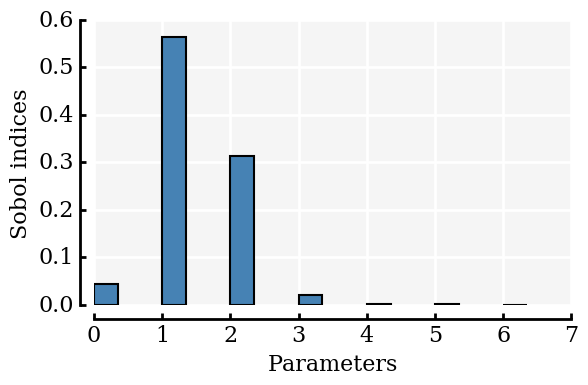

In [6]:
statistics.plot()

<h3> References

1. Blatman, Géraud, and Bruno Sudret. "Adaptive sparse polynomial chaos expansion based on least angle regression." Journal of Computational Physics 230.6 (2011): 2345-2367.
2. Kenett, Ron, Shelemyahu Zacks, and Daniele Amberti. Modern Industrial Statistics: with applications in R, MINITAB and JMP. John Wiley & Sons, 2013.
3. Owen, Art B., Josef Dick, and Su Chen. "Higher order Sobol'indices." Information and Inference 3.1 (2014): 59-81.